# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st

## Загрузка и подготовка данных

In [3]:
# откроем все файлы
try:
    df0 = pd.read_csv('/datasets/geo_data_0.csv')
    df1 = pd.read_csv('/datasets/geo_data_1.csv')
    df2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    df0 = pd.read_csv('geo_data_0.csv')
    df1 = pd.read_csv('geo_data_1.csv')
    df2 = pd.read_csv('geo_data_2.csv')


**Рассмотрим все датафреймы**

*начнем с первого*

In [3]:
df0.info()
df0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
# рассмоттри уникальность объектов
df0['id'].value_counts().head(15)

TtcGQ    2
bxg6G    2
AGS9W    2
A5aEY    2
HZww2    2
Tdehs    2
74z30    2
fiKDv    2
bsk9y    2
QcMuo    2
U16RG    1
QOWY0    1
IBqEt    1
WclZX    1
asm5K    1
Name: id, dtype: int64

In [5]:
# в выборке есть повторяющиеся объекты, оставим только те, у которых ментше запас
x_idx = list(df0['id'].value_counts().head(10).index)
idx_drop = []
for i in x_idx:
    idx_drop.append(df0[df0['id'] == i]['product'].idxmax())
df0 = df0.drop(labels=idx_drop)
df0 = df0.set_index('id')

In [6]:
# немного понизим разряд, одинарной точности нам достаточно
df0 = df0.astype({'f0':'float32', 
                  'f1':'float32', 
                  'f2':'float32', 
                  'product':'float32'}) 

In [7]:
# получаем симпатичный датасет
df0.info()
df0.head()

<class 'pandas.core.frame.DataFrame'>
Index: 99990 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99990 non-null  float32
 1   f1       99990 non-null  float32
 2   f2       99990 non-null  float32
 3   product  99990 non-null  float32
dtypes: float32(4)
memory usage: 2.3+ MB


,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497822,1.221170,105.280060
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265648
iJLyR,-0.032172,0.139033,2.978566,168.620773
Xdl7t,1.988431,0.155413,4.751769,154.036652


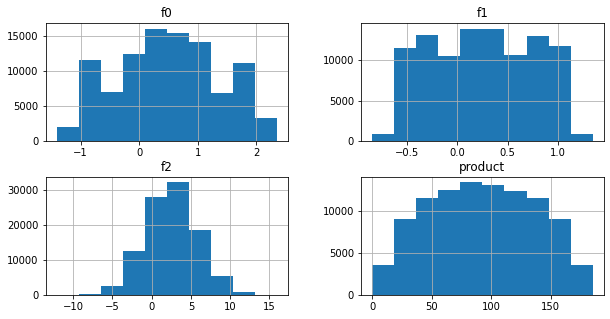

In [8]:
df0.hist(figsize=(10,5));

*переходим ко второму*

In [9]:
# совершаем все те же махинации с данными
df1.info()
df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [10]:
df1['id'].value_counts().head(15)

LHZR0    2
5ltQ6    2
wt4Uk    2
bfPNe    2
JuzO5    1
o05ut    1
k6QIv    1
mNwLO    1
KNhV1    1
GVhsq    1
KPsm9    1
WKplV    1
F2iag    1
bKRfa    1
DPwlQ    1
Name: id, dtype: int64

In [11]:
x_idx = list(df1['id'].value_counts().head(4).index)
idx_drop = []
for i in x_idx:
    idx_drop.append(df1[df1['id'] == i]['product'].idxmax())
df1 = df1.drop(labels=idx_drop)
df1 = df1.set_index('id')

In [12]:
df1 = df1.astype({'f0':'float32', 
                  'f1':'float32', 
                  'f2':'float32', 
                  'product':'float32'}) 

In [13]:
df1.info()
df1.head()

<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99996 non-null  float32
 1   f1       99996 non-null  float32
 2   f2       99996 non-null  float32
 3   product  99996 non-null  float32
dtypes: float32(4)
memory usage: 2.3+ MB


,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953260
vyE1P,6.263187,-5.948386,5.001160,134.766312
KcrkZ,-13.081196,-11.506057,4.999415,137.945404
AHL4O,12.702195,-8.147433,5.004363,134.766312


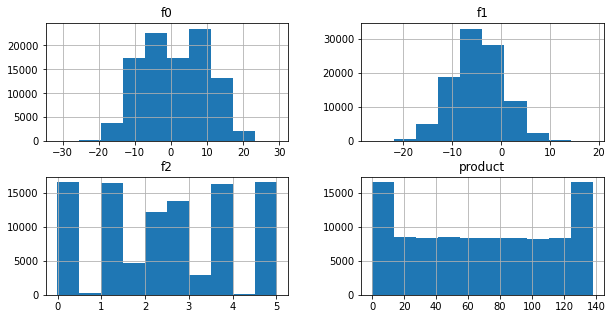

In [14]:
df1.hist(figsize=(10,5));

*переходим к третьему*

In [15]:
# совершаем все те же махинации с данными
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [16]:
df2['id'].value_counts().head(15)

xCHr8    2
Vcm5J    2
KUPhW    2
VF7Jo    2
wD7z8    1
YCqiE    1
D122W    1
tsGJj    1
YroqQ    1
Y63vs    1
tHxlc    1
vtgJA    1
VzbU0    1
efdh1    1
wQC8c    1
Name: id, dtype: int64

In [17]:
x_idx = list(df2['id'].value_counts().head(4).index)
idx_drop = []
for i in x_idx:
    idx_drop.append(df2[df2['id'] == i]['product'].idxmax())
df2 = df2.drop(labels=idx_drop)
df2 = df2.set_index('id')

In [18]:
df2 = df2.astype({'f0':'float32', 
                  'f1':'float32', 
                  'f2':'float32', 
                  'product':'float32'}) 

In [19]:
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99996 non-null  float32
 1   f1       99996 non-null  float32
 2   f2       99996 non-null  float32
 3   product  99996 non-null  float32
dtypes: float32(4)
memory usage: 2.3+ MB


,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530186,56.069698
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572845
WPMUX,-0.515993,1.716266,5.899012,149.600739


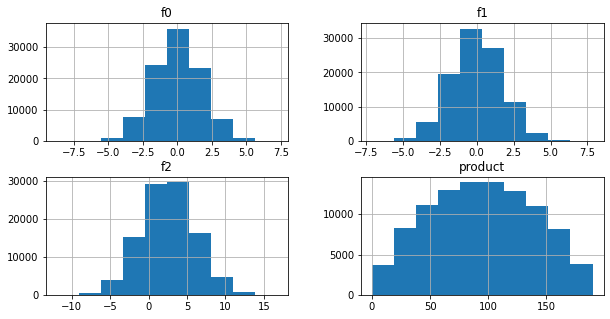

In [20]:
df2.hist(figsize=(10,5));

**Данные изначально хорошо подготовлены для дальнейшего обучения
<br>Единственное довел до одинарной точности, а так же преобрал столбец в индекс, поскольку там уникальные значения**

## Обучение и проверка модели

**Приступим обучать модели для каждого региона
<br>Предварительно разобьем данные**

In [21]:
X_0 = df0.drop('product',axis=1)
y_0 = df0['product']

X_train_0, X_val_0, y_train_0, y_val_0 = train_test_split(X_0, y_0, test_size = 0.25, random_state=12345)

print(f"Размер выборки train: X:{X_train_0.shape}, y:{y_train_0.shape}")
print(f"Размер выборки validation: X:{X_val_0.shape}, y:{y_val_0.shape}")

Размер выборки train: X:(74992, 3), y:(74992,)
Размер выборки validation: X:(24998, 3), y:(24998,)


In [22]:
X_1 = df1.drop('product',axis=1)
y_1 = df1['product']

X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_1, y_1, test_size = 0.25, random_state=12345)

print(f"Размер выборки train: X:{X_train_1.shape}, y:{y_train_1.shape}")
print(f"Размер выборки validation: X:{X_val_1.shape}, y:{y_val_1.shape}")

Размер выборки train: X:(74997, 3), y:(74997,)
Размер выборки validation: X:(24999, 3), y:(24999,)


In [23]:
X_2 = df2.drop('product',axis=1)
y_2 = df2['product']

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_2, y_2, test_size = 0.25, random_state=12345)

print(f"Размер выборки train: X:{X_train_2.shape}, y:{y_train_2.shape}")
print(f"Размер выборки validation: X:{X_val_2.shape}, y:{y_val_2.shape}")

Размер выборки train: X:(74997, 3), y:(74997,)
Размер выборки validation: X:(24999, 3), y:(24999,)


*Для первого региона*

In [24]:
model_0 = LinearRegression()
model_0.fit(X_train_0, y_train_0)
model_0_pred = model_0.predict(X_val_0)
model_0_res = pd.DataFrame({ 'y' : y_val_0, 'y_pred' : model_0_pred})
print(f"Mean product {model_0_res['y_pred'].mean()}")
print(f"RMSE : {mean_squared_error(model_0_res['y'], model_0_res['y_pred']) ** 0.5}")

Mean product 92.60974884033203
RMSE : 37.593611998395914


*Для второго региона*

In [25]:
model_1 = LinearRegression()
model_1.fit(X_train_1, y_train_1)
model_1_pred = model_1.predict(X_val_1)
model_1_res = pd.DataFrame({ 'y' : y_val_1, 'y_pred' : model_1_pred})
print(f"Mean product {model_1_res['y_pred'].mean()}")
print(f"RMSE : {mean_squared_error(model_1_res['y'], model_1_res['y_pred']) ** 0.5}")

Mean product 69.00110626220703
RMSE : 0.8910677629106567


*Для третьего региона*

In [26]:
model_2 = LinearRegression()
model_2.fit(X_train_2, y_train_2)
model_2_pred = model_2.predict(X_val_2)
model_2_res = pd.DataFrame({ 'y' : y_val_2, 'y_pred' : model_2_pred})
print(f"Mean product {model_2_res['y_pred'].mean()}")
print(f"RMSE : {mean_squared_error(model_2_res['y'], model_2_res['y_pred']) ** 0.5}")

Mean product 94.94690704345703
RMSE : 40.270153994420916


## Подготовка к расчёту прибыли

In [27]:
# зададим константы
INCOME = 450_000 # прибыль с одиницы товара
BUDGET = 10_000_000_000 # бюджет
PROBABILITY_OF_LOSSES = 0.025 # вероятность убытков
POINTS = 500 # количество исследуемых точек
BEST_POINTS = 200 # количество лучших точек
BUDGET_FOR_ONE = BUDGET / BEST_POINTS # Бюджет на одну скважину

In [28]:
# смотрим, сколько нужно объем скважины для беубыточности
break_even = BUDGET_FOR_ONE / INCOME
print(f"Безубыточный объем скважины: {break_even}")

Безубыточный объем скважины: 111.11111111111111


In [29]:
# сравниваем со средними значениями
for i in enumerate(['y_'+str(i) for i in range(3)]):
    print(f"В регионе - {i[0]} средний запас: {eval(i[1]).mean()}")
    if eval(i[1]).mean() < break_even:
        print(f"Что недостаточно для окупаемости - mean < {break_even:.2f}\n")
    else:
        print("Достаточно для окупаемости\n")

В регионе - 0 средний запас: 92.49742126464844
Что недостаточно для окупаемости - mean < 111.11

В регионе - 1 средний запас: 68.82341003417969
Что недостаточно для окупаемости - mean < 111.11

В регионе - 2 средний запас: 94.99742889404297
Что недостаточно для окупаемости - mean < 111.11



**Исходя из средних значений по регионам, можно сделать вывод, что данной информации недостаточно, поскольку данных значений недостаточно для окупаемости. Нужно выбирать скважины с подходящими значениями**

## Расчёт прибыли и рисков 

In [30]:
# Функция расчета прибыли
def well_profit(model_res, best_points, income, budget):
    well_max = model_res.loc[model_res.sort_values('y_pred', ascending=False).index]
    well_max = well_max[:best_points]
    sum_well = well_max['y'].sum()
    profit_pred = (sum_well * income) - budget
    return profit_pred, sum_well

In [31]:
for i in range(3):
    print(f"Объем с лучших скважин региона {i} : {well_profit(eval('model_'+str(i)+'_res'), BEST_POINTS, INCOME, BUDGET)[1]*1000:.2f} баррелей")
    print(f"Доход с лучших скважин региона {i} : {well_profit(eval('model_'+str(i)+'_res'), BEST_POINTS, INCOME, BUDGET)[0]} рублей\n")

Объем с лучших скважин региона 0 : 29373976.56 баррелей
Доход с лучших скважин региона 0 : 3218289453.125 рублей

Объем с лучших скважин региона 1 : 27589085.94 баррелей
Доход с лучших скважин региона 1 : 2415088671.875 рублей

Объем с лучших скважин региона 2 : 27553957.03 баррелей
Доход с лучших скважин региона 2 : 2399280664.0625 рублей



## Расчёт прибыли и рисков

*Рассмотрим среднюю прибыль на первом участке*

In [32]:
values = []
count = 0
state = np.random.RandomState(12345)
for i in range(1000):
    subsample = model_0_res.sample(500, replace=True, random_state=state)
    values.append(well_profit(subsample, BEST_POINTS, INCOME , BUDGET)[0])

values = pd.Series(values)
confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
low = values.quantile(0.025)
high = values.quantile(0.975)
loss = (values < 0).sum()/len(values)


print(f'Средняя прибыль: {values.mean():.2f}')
print(f'Доверительный интервал {confidence_interval[0]} : {confidence_interval[1]}')
print(f'Риск убытков : {loss}')

Средняя прибыль: 425492914.06
Доверительный интервал 408780257.2258471 : 442205570.8991529
Риск убытков : 0.053


*Рассмотрим среднюю прибыль на втором участке*

In [33]:
values = []
count = 0
state = np.random.RandomState(12345)
for i in range(1000):
    subsample = model_1_res.sample(500, replace=True, random_state=state)
    values.append(well_profit(subsample, BEST_POINTS, INCOME, BUDGET)[0])

values = pd.Series(values)
confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
low = values.quantile(0.025)
high = values.quantile(0.975)
loss = (values < 0).sum()/len(values)


print(f'Средняя прибыль: {values.mean():.2f}')
print(f'Доверительный интервал {confidence_interval[0]} : {confidence_interval[1]}')
print(f'Риск убытков : {loss}')

Средняя прибыль: 514553772.85
Доверительный интервал 500889552.1377779 : 528217993.5653471
Риск убытков : 0.007


*Рассмотрим среднюю прибыль на третьем участке*

In [34]:
values = []
count = 0
state = np.random.RandomState(12345)
for i in range(1000):
    subsample = model_2_res.sample(500, replace=True, random_state=state)
    values.append(well_profit(subsample, BEST_POINTS, INCOME, BUDGET)[0])

values = pd.Series(values)
confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
low = values.quantile(0.025)
high = values.quantile(0.975)
loss = (values < 0).sum()/len(values)


print(f'Средняя прибыль: {values.mean():.2f}')
print(f'Доверительный интервал {confidence_interval[0]} : {confidence_interval[1]}')
print(f'Риск убытков : {loss}')

Средняя прибыль: 343229391.41
Доверительный интервал 325737046.475388 : 360721736.337112
Риск убытков : 0.103


**В регионе с индексом 0 и 2, риски привышают 2.5% - он нам не подходит
<br>Во регионе 1 риски меньше и наибольшая средняя прибыль
<br> Который в свою очередь и стоит выбрать**

**Выводы:
<br>1) Были приедоставленны хорошие данные, которые понизили разрядность и избавились от дубликатов
<br>2) Данные были обучены с помощью линейной регресси для предсказания объемов, в отношении 75:25
<br>3) Рассмотрев только средние значения, оказалось сложно предугадать, на какой территории стоит начать работы
<br>4) Поэтому были определены точки с наибольшим объемом ресурсов и подсчитана прибыль для каждой
<br>5) Далее с помощью бутстрап определялась средняя прибыль по каждому региону
<br>6) И рассмотрев результаты, было принято решение ставить оборудование в регионе под индексом 1, в надежде получить 514553772.85 рублей, с минимальными рисками меньше процента**

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован